In [87]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import multivariate_normal as mvn
from util import plot_linear_boundary

# Logistic Regression

$$\mathbb{P}(y=1) =\frac{1}{1 + \exp{(-\mathbf{z}})} = \frac{\exp{(\mathbf{z}})}{1 + \exp{(\mathbf{z}})}, \quad \mathbf{z} = \mathbf{w} \cdot \mathbf{x} + b$$

## Data Generation

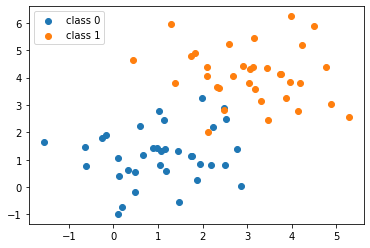

In [88]:
# Generate data
N = 50
seed = 0
X0 = mvn.rvs(mean=[1, 1], cov=np.eye(2), size = N, random_state=seed)
X1 = mvn.rvs(mean=[3, 4], cov=np.eye(2), size = N, random_state=seed)
Y0 = np.repeat(0, N)
Y1 = np.repeat(1, N)
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([Y0, Y1], axis=0)

# Shuffle
shuffle_idx = np.arange(2*N)
shuffle_rng = np.random.RandomState(seed)
shuffle_rng.shuffle(shuffle_idx)
X, Y = X[shuffle_idx], Y[shuffle_idx]

# Train, test split
X_train, Y_train, X_test, Y_test = X[:70], Y[:70], X[70:], Y[70:]

# Plot the training set
fig, ax = plt.subplots()
ax.scatter(X_train[Y_train == 0, 0], X_train[Y_train == 0, 1], label="class 0")
ax.scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], label="class 1")
ax.legend()
plt.show()


# Low Level Implementation - manual gradient

In [89]:
class LogisticRegression():
    def __init__(self) -> None:
        self.weights = None
    
    def initialise_weights(self, n_features):
        self.weights = torch.rand(n_features, 1, dtype=torch.float32)
    
    def add_ones(self, X):
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        X = torch.from_numpy(X).float()
        return X

    def _sigmoid(self, z):
        s = 1. / (1. +  torch.exp(-z))
        return s
    
    def forward(self, x):
        z = torch.mm(x, self.weights)
        probas = self._sigmoid(z)
        return probas

    def backward(self, probas, y):
        errors = y - probas.view(-1)
        return errors 

    def train(self, X, y, epochs, rate):
        X = self.add_ones(X)
        y = torch.from_numpy(y).float()
        n_features = X.shape[1]
        self.initialise_weights(n_features)

        for e in range(epochs):
            probas = self.forward(X)
            errors = self.backward(probas, y)
            neg_grad = torch.matmul(X.transpose(0, 1), errors.view(-1, 1))
            self.weights += rate * neg_grad  

    def predict(self, X):
        X = self.add_ones(X)
        probas = torch.matmul(X, self.weights)
        return (probas > 0.5) * 1

    def evaluate(self, X, y):
        pred = self.predict(X).view(-1).numpy()
        acc = sum(pred == y) / y.shape[0] * 100
        return acc

In [90]:
lr_clf = LogisticRegression()

lr_clf.train(X_train, Y_train, 100, 0.01)

train_acc = lr_clf.evaluate(X_train, Y_train)
test_acc = lr_clf.evaluate(X_test, Y_test)

print("Training accuracy: {:.2f}%".format(train_acc))
print("Test accuracy: {:.2f}%".format(test_acc))


Training accuracy: 95.71%
Test accuracy: 93.33%


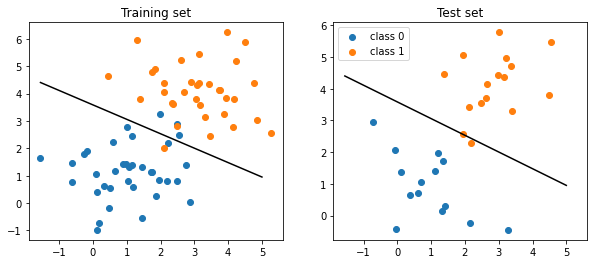

In [91]:
w = lr_clf.weights.numpy()[1:]
b = lr_clf.weights.numpy()[0]

plot_linear_boundary(X_train, Y_train, X_test, Y_test, w, b)

## High level implementation with nn.Module API

In [92]:
class LogisticRegression2(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression2, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)

    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas
    
    def evaluate(self, probas, y):
        pred = (probas > 0.5).view(-1) * 1
        acc = torch.sum(pred == y.view(-1)).float() / y.size(0)
        return acc.numpy()

In [93]:
model = LogisticRegression2(num_features=2)

cost_fn = torch.nn.BCELoss(reduction='sum')

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 100

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

train_acc = []
test_acc = []

for epoch in range(num_epochs):
    
    out = model(X_train_tensor)
    
    # Compute the gradient
    cost = cost_fn(out, y_train_tensor)
    optimizer.zero_grad()
    cost.backward()
    
    # Update the weights
    optimizer.step()
    
    # Logging
    train_acc.append(model.evaluate(model(X_train_tensor), y_train_tensor))
    test_acc.append(model.evaluate(model(X_test_tensor), y_test_tensor))


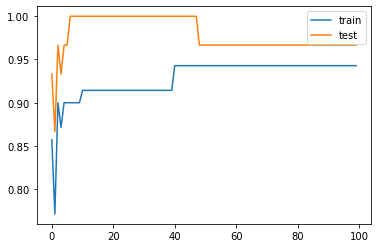

In [94]:
plt.plot(train_acc, label="train")
plt.plot(test_acc, label="test")
plt.legend()
plt.show()

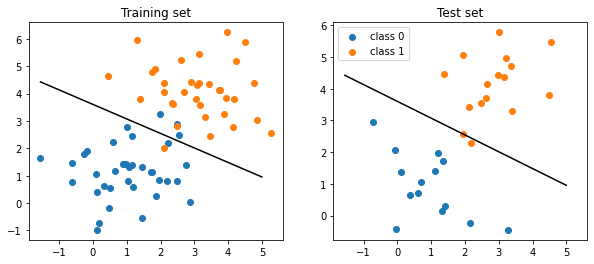

In [95]:
w = model.linear.weight.detach().numpy()[0]
b = model.linear.bias.detach().numpy()

plot_linear_boundary(X_train, Y_train, X_test, Y_test, w, b)